# GCExplainer

In [1]:
import os,sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

---

### Model & Data

In [2]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, KNNGraph
import torch
graph_aug_val = Compose([KNNGraph(k=6)])

src_folder  = "C:\\Users\\aless\\Documents\\data"
tid,vid = BACH.get_train_val_ids(src_folder)
train_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

print(len(train_loader))
print(len(val_loader))

308
76


In [3]:
# Model

from src.model.architectures.cancer_prediction.cancer_gnn import CancerGNN

model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model", "GCN_Long.ckpt"),WIDTH=32,HEIGHT=7)
model.eval()
model.requires_grad_(False)
print(model.predictor)

Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=64, out_features=32, bias=True)
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0, inplace=False)
  (5): Linear(in_features=32, out_features=4, bias=True)
)


---
## Dataset Metrics

In [4]:
import torch
def calculate_set_metric(loader,model,metric):
    tot = 0
    for batch in loader:
        ans = model(batch.x,batch.edge_index,batch.batch)
        tot += metric(ans,batch.y)
    return tot/len(loader)

def accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat == y).sum()

def cancer_accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat <=1) ==(y<=1 ).sum()
    
print("Training Loss",calculate_set_metric(train_loader,model,torch.nn.CrossEntropyLoss()))
print("Validation Loss",calculate_set_metric(val_loader,model,torch.nn.CrossEntropyLoss()))
print("Training Accuracy",calculate_set_metric(train_loader,model,accuracy))
print("Validation Accuracy",calculate_set_metric(val_loader,model,accuracy))
print("Training Cancer Accuracy",calculate_set_metric(train_loader,model,cancer_accuracy))
print("Validation Cancer Accuracy",calculate_set_metric(val_loader,model,cancer_accuracy))


Training Loss tensor(0.3051)
Validation Loss tensor(0.5629)
Training Accuracy tensor(0.9318)
Validation Accuracy tensor(0.8158)
Training Cancer Accuracy tensor([0.9708])
Validation Cancer Accuracy tensor([0.8684])


[Text(0, 0.5, 'Normal'),
 Text(0, 1.5, 'Benign'),
 Text(0, 2.5, 'In Situ'),
 Text(0, 3.5, 'Invasive')]

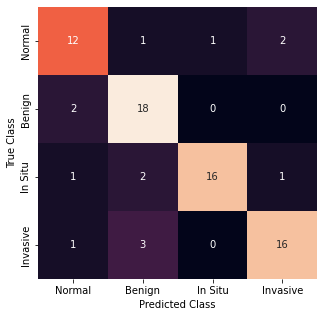

In [6]:
from src.model.evaluation.confusion_matrix import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

pred, gt = [],[]
for graph in val_loader:
    ans = model(graph.x,graph.edge_index,graph.batch)
    pred.append(ans.argmax(dim=1).item()), gt.append(graph.y.item())
    
f = plt.figure(figsize=(5,5))
ax = sns.heatmap(confusion_matrix(torch.tensor(gt),torch.tensor(pred),num_classes=4),annot=True, fmt=".0f",cbar=False,)
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_xticklabels(["Normal","Benign","In Situ","Invasive"])
ax.set_yticklabels(["Normal","Benign","In Situ","Invasive"])

---

### Get Raw Activations

In [7]:

# Attach the hook

batch = next(iter(train_loader))
raw_activations = torch.zeros(0,32)

def append_raw_activations(self, input, output):
    global raw_activations
    raw_activations = torch.cat((raw_activations,output),dim=0)



model.gnn.conv[-1].register_forward_hook(append_raw_activations)



In [8]:
# Acquire the activations
raw_activations = torch.zeros(0,32)
predictions = torch.zeros(0)
ground = torch.zeros(0)
for batch in train_loader:
    num_elems = batch.x.shape[0]
    predictions = torch.cat([predictions,torch.zeros(num_elems)+model(batch.x,batch.edge_index,batch.batch).argmax()])
    ground = torch.cat([ground,(torch.zeros(num_elems)+batch.y)])

predictions = torch.as_tensor(predictions)
ground = torch.as_tensor(ground)
#for batch in val_loader:
#    model(batch.x,batch.edge_index,batch.batch)

In [9]:
print(raw_activations.shape)

torch.Size([280840, 32])


In [10]:
for i,b in enumerate(train_loader):
    if(b.graph_id==102):
        print(i)
print(val_loader.dataset[2])

73
Data(edge_index=[2, 1848], x=[308, 315], pos=[308, 2], categories=[308], num_neighbours=[308], y=[1], graph_id=2)


---
# K Means

In [11]:
def nearest_mean(x,means):

    delta = (means - x)**2
    dists = delta.sum(axis=1)
    return dists.argmin()

def cluster(obs,means,k):
    clusters = [[] for i in range(k)]
    for i,x in enumerate(obs):
        clusters[nearest_mean(x,means)].append(i)
    return clusters


In [12]:
from sklearn.cluster import KMeans,MiniBatchKMeans

import numpy as np
k_small = 6
k_large = 32

tsne_size = 10000

obs = raw_activations.detach().numpy()
mu,sigma = obs.mean(axis=0),obs.std(axis=0)

print(len(obs))
def whiten(obs):
    return (obs - mu)/sigma

obs_white = whiten(obs)
means_small = MiniBatchKMeans(n_clusters= k_small).fit(obs_white).cluster_centers_
means_large = MiniBatchKMeans(n_clusters=k_large).fit(obs_white).cluster_centers_



np.random.seed(7)
subset = np.random.choice(np.arange(len(obs)),size=tsne_size,replace=False)
obs = obs[subset]
obs_white = whiten(obs)

clusters_small = cluster(obs_white,means_small,k_small)
clusters_large = cluster(obs_white,means_large,k_large)


280840


---
# Vizualize Explanations

In [13]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA



t =TSNE(n_components=2,learning_rate ='auto',verbose=2,perplexity = 1000,n_iter=700).fit_transform(obs_white)
#reducer = PCA(n_components=2).fit(obs)
#reducer = KernelPCA(n_components=2,kernel="rbf",degree=2).fit(smaller_obs)

d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 3001 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 4.295s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.521837
[t-SNE] Computed conditional probabilities in 7.457s
[t-SNE] Iteration 50: error = 55.6525993, gradient norm = 0.0000006 (50 iterations in 13.586s)
[t-SNE]

In [14]:

import matplotlib.pyplot as plt
from matplotlib import cm

def plot_concept_clusters(cluster_ids,values):
    f = plt.figure(figsize=(10,10))
    plt.axis("off")
    colours = cm.rainbow(np.linspace(0,1,len(cluster_ids)))
    for i,clust_ids in enumerate(cluster_ids):
        v = values[clust_ids]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])
    plt.show()

def plot_cancer_clusters(cancer_type,values):
    colours = cm.rainbow(np.linspace(0,1,4))
    #f = plt.figure(figsize=(10,10))
    #plt.axis("off")
    for i in range(4):
        nodes_with_cancer_type = (cancer_type==i)
        v = values[nodes_with_cancer_type]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])
        plt.show()

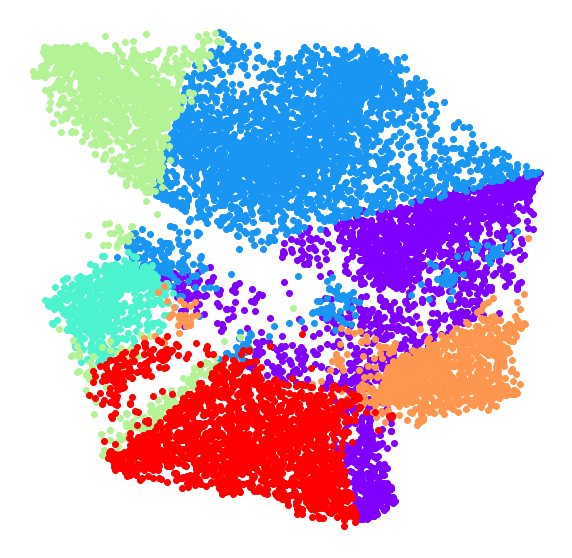

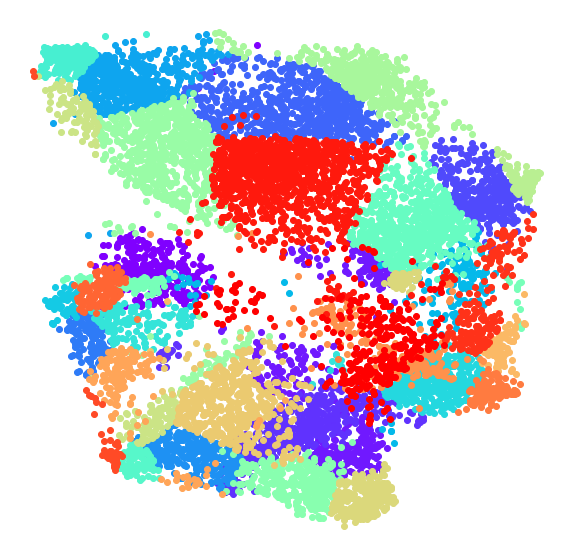

280840


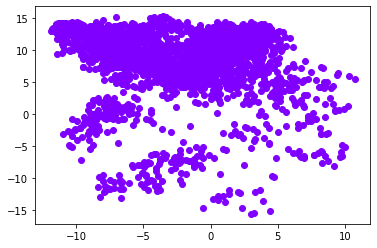

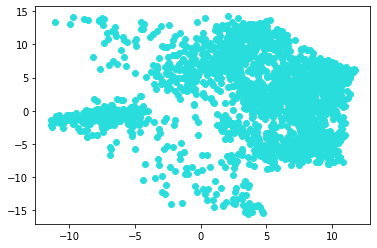

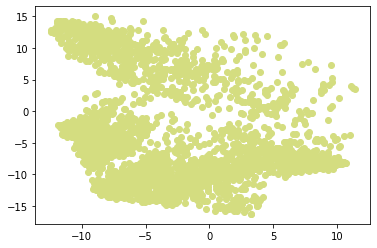

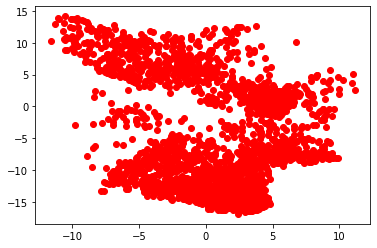

In [15]:
plot_concept_clusters(clusters_small,t) # clusters and t must be whitened
plot_concept_clusters(clusters_large,t) # clusters and t must be whitened
print(len(predictions))
plot_cancer_clusters(predictions[subset],t)

---
# Concept Completeness

In [16]:
# Activation Graph to Concept Graph


# Attach the hook

activations = []

def save_activation_graph(self, input, output):
    global activations
    activations.append(output)



model.gnn.conv[-1].register_forward_hook(save_activation_graph)



In [17]:
from torch.nn.functional import one_hot

def activation_to_concept(activation,means):
    return one_hot(torch.as_tensor(nearest_mean(activation,means)),len(means))

def activation_to_concept_graph(activations,means,k):
    output = torch.zeros(0,k)
    for i in range(len(activations)):
        concept = activation_to_concept(whiten(activations[i]).numpy(),means).unsqueeze(0)
        output = torch.cat([output,concept],dim=0)
    return output


def predict_activation_concept_from_graph(graph,means,k):
    global activations
    activations = []
    model(graph.x,graph.edge_index,graph.batch)
    ag = activations[0]
    return ag,activation_to_concept_graph(ag,means,k)



In [20]:

from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data

def vizualize_concept_graph(graph,means,k):
    print(graph.y)
    _,x = predict_activation_concept_from_graph(graph,means,k)
    print((x.sum(dim=0)>(len(x)/10)).sum())
    edge_index  = graph.edge_index
    pos = {i:tuple(graph.pos[i]) for i in range(len(graph.pos))}
    colours = cm.rainbow(np.linspace(0,1,k))
    node_colours = [colours[i] for i in x.argmax(dim=1)]
    
    g = Data(x=x,edge_index=edge_index,pos=pos)
    G = to_networkx(graph,to_undirected=True)

   # f,ax = plt.subplots(1,1,figsize=(20,20))
    plt.figure(figsize=(graph.pos[:,0].max()/100,graph.pos[:,1].max()/100))
    plt.axis([0,graph.pos[:,0].max(),graph.pos[:,1].max(),0])
    nx.draw(G,pos=pos,node_color=node_colours,node_size=100)
    plt.show()

tensor([1])
tensor(3)


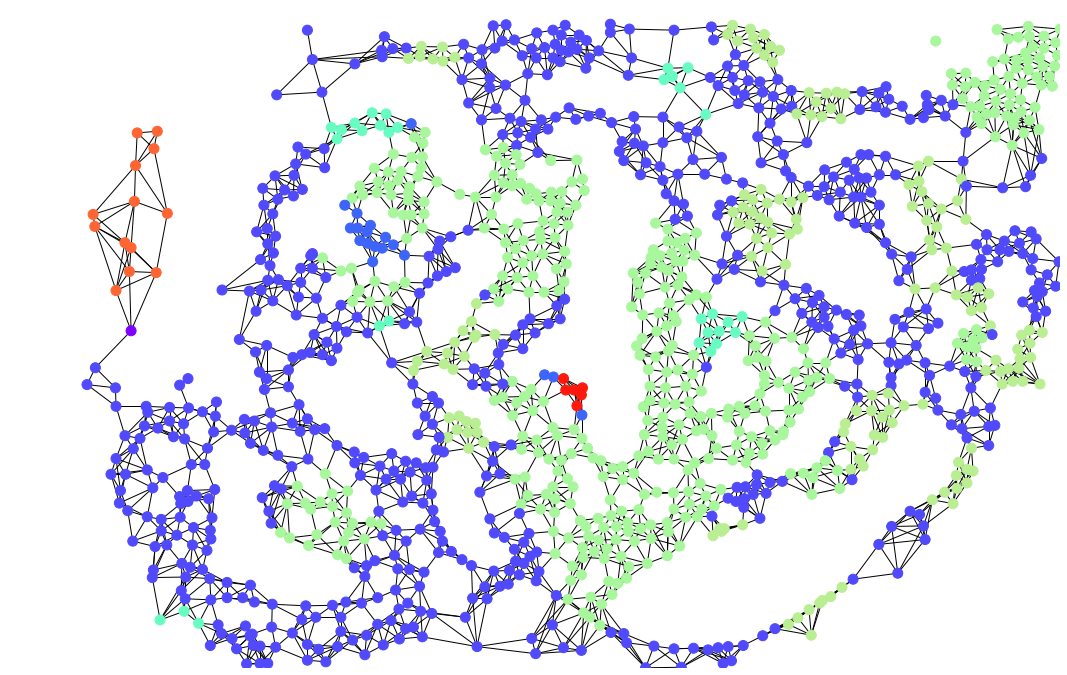

In [21]:
vizualize_concept_graph(train_loader.dataset[73],means_large,k_large)

---

In [18]:
def concept_vs_cancer(loader): return [(predict_activation_concept_from_graph(batch,means_large,k_large)[1].mean(dim=0),batch.y) for batch in loader]

In [19]:
x_train = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(train_loader))))
y_train = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(train_loader))))

x_val = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(val_loader))))
y_val = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(val_loader))))

In [20]:
def plot_agg_concept_for_class(cls,x,y):
    f = plt.figure(figsize=(20,10))
    ind = y==cls
    assert len(x) == len(y)

    plt.imshow(x[ind].reshape(k_large,-1))


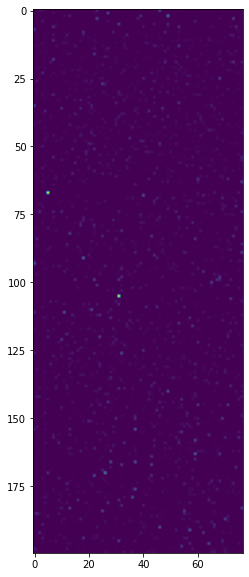

In [21]:
plot_agg_concept_for_class(1,x_train,y_train)

In [22]:
torch.as_tensor(x_train).max(dim=0)

torch.return_types.max(
values=tensor([0.1335, 0.1490, 0.1228, 0.3376, 0.0885, 0.0962, 0.0556, 0.1043, 0.2988,
        0.0473, 0.2657, 0.1461, 0.0610, 0.0827, 0.1587, 0.2887, 0.1687, 0.1270,
        0.0988, 0.2412, 0.0959, 0.0606, 0.1523, 0.2298, 0.1533, 0.3071, 0.2159,
        0.1167, 0.1164, 0.2991, 0.2688, 0.0962, 0.1570, 0.1335, 0.1350, 0.1818,
        0.4787, 0.2504, 0.1037, 0.2604, 0.0484, 0.0559, 0.0858, 0.1092, 0.1552,
        0.1587, 0.5211, 0.1000, 0.1125, 0.0564, 0.1082, 0.1260, 0.0930, 0.0870,
        0.2937, 0.1122, 0.1250, 0.0769, 0.2196, 0.1466, 0.4029, 0.0437, 0.1640,
        0.1363, 0.1602, 0.1186, 0.2150, 0.0962, 0.2050, 0.1720, 0.0733, 0.1298,
        0.0727, 0.0832, 0.1635, 0.0793, 0.2578, 0.1190, 0.1601, 0.1164, 0.0577,
        0.4149, 0.0501, 0.2500, 0.7153, 0.2233, 0.0722, 0.1354, 0.4628, 0.1740,
        0.1306, 0.1852, 0.3114, 0.1029, 0.0538, 0.2350, 0.1208, 0.0760, 0.0920,
        0.1129, 0.1071, 0.1221, 0.1792, 0.1214, 0.4010, 0.1972, 0.0917, 0.4038,
        0

In [32]:
def generate_concept_to_class_set(train_loader,means,k):

    X_train = torch.zeros(0,k)
    Y_train = torch.zeros(0)

    for graph in train_loader:
        num_nodes = len(graph.x)
        y = torch.zeros(num_nodes) + graph.y
        _,x = predict_activation_concept_from_graph(graph,means,k)
        X_train = torch.cat([X_train,x],dim=0)
        Y_train = torch.cat([Y_train,y],dim=0)
    return X_train,Y_train


In [ ]:
X_train,Y_train = generate_concept_to_class_set(train_loader,means_large,k_large)
X_val,Y_val = generate_concept_to_class_set(val_loader,means_large,k_large)

---
### CBE

In [ ]:
## Linear Model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree


l = tree.DecisionTreeClassifier(criterion="entropy").fit(X_train,Y_train)

tree.plot_tree(l)

print(l.score(X_train,Y_train))
print(l.score(X_val,Y_val))



In [33]:
# See P(class|concept)
from tqdm import tqdm
from torch.nn.functional import normalize


def class_concept_joint_frequency(CLS,CONCEPT,k):
    class_concept = torch.zeros(4,k)
    for cons,cl in tqdm(zip(CONCEPT,CLS)):
        class_concept[cl.int(),cons.argmax()] += 1
    return class_concept
    

In [34]:

def class_condition_concepts_prob(joint_freq,concepts): # concepts in number form
    output = torch.zeros(4)
    joint_freq+=1
    def _p_class(cl): return joint_freq[cl].sum()/joint_freq.sum()
    def _p_concept(cons): return joint_freq[:,cons].sum()/joint_freq.sum()
    def _p_concept_given_class(cons,cl): return joint_freq[cl,cons]/joint_freq[cl].sum()
    for cl in range(4):
        tot = torch.log(_p_class(cl))
        for cons in concepts:
            tot  += torch.log(_p_concept_given_class(cons,cl))
            tot -= torch.log(_p_concept(cons))
        output[cl] = tot
    return output       
        
    

In [ ]:
freq = class_concept_joint_frequency(Y_train,X_train)
class_condition_concepts_prob(freq,X_train[0:10000])

NameError: name 'Y_train' is not defined

In [ ]:
from torch.nn.functional import normalize

z = normalize(freq,dim=1,p=1)
y = torch.zeros(k,2)
y[:,0] = z[:,0]+z[:,1]
y[:,1] = z[:,2]+z[:,3]
y

NameError: name 'freq' is not defined

In [ ]:
z

NameError: name 'z' is not defined

---
# Deducing K


1) Choose K
2) Get Convert list of graphs to list of (activation, graph id)
3) Get list (graph_id, ground_truth, pred_truth)
4) Generate means and hence concepts from activations
5) Get concepts from activations
6) Use decision tree to predict (concept-> cancer_type)
7) Evaluate how accurate
8) **Define concept prevelance score** and evaluate. If below certain threshold
9) Increment K and plot.

In [22]:
def generate_concept_means(model,train_loader,k):
    global raw_activations
    raw_activations = torch.zeros(0,32)

    for batch in tqdm(train_loader):
        model(batch.x,batch.edge_index,batch.batch)

    #for batch in val_loader:
    #    model(batch.x,batch.edge_index,batch.batch)

    obs = raw_activations.detach().numpy()
    mu,sigma = obs.mean(axis=0),obs.std(axis=0)

    def whiten(obs):
        return (obs - mu)/sigma

    obs_white = whiten(obs)
    means = MiniBatchKMeans(n_clusters=k,batch_size=10000).fit(obs_white).cluster_centers_
    return means

In [23]:
from tqdm import tqdm
import sklearn.tree as tree

def first(x): return x[0]
def second(x): return x[1]
def third(x): return x[2]



def deduce_k(train_loader,val_loader,model,max_k=60,increments=6,start_k=10):
    global activations
    ks = []
    dt_scores_val = []
    dt_scores_train = []
    predictive_power_node = []
    predictive_power_subgraph = []
    prevelance = []
    for k in tqdm(range(start_k,max_k,increments)):
        #Generate
        means = generate_concept_means(model,train_loader,k)
        
    
        
        X_train,Y_train = generate_concept_to_class_set(train_loader,means,k)
        X_val,Y_val = generate_concept_to_class_set(val_loader,means,k)
        freq = class_concept_joint_frequency(Y_train,X_train,k) +1
        
        
        #Train

        
        dt = tree.DecisionTreeClassifier(criterion="entropy").fit(X_train,Y_train)
        
        
        
        #Test
        node_correct = 0
        subgraph_correct = 0

        concept_prev = torch.zeros(k)
        for graph in val_loader:
            
            concept_graph = activation_graph_to_concept_graph(graph,means,k)
            concepts = concept_graph.x.argmax(dim=1)
            sub_graphs_concepts = set(map(lambda g: g.concept.item(),disect_concept_graph(concept_graph)))
            #print(class_condition_concepts_prob(freq,concepts).argmax(),graph.y)
            node_correct += 1 if class_condition_concepts_prob(freq,concepts).argmax() == graph.y else 0
            subgraph_correct += 1 if class_condition_concepts_prob(freq,list(sub_graphs_concepts)).argmax() == graph.y else 0
            for concept in sub_graphs_concepts: 
                concept_prev[concept] +=1
        prevelance.append(concept_prev/len(val_loader))
        
        ks.append(k)
        dt_scores_val.append(dt.score(X_val,Y_val))
        dt_scores_train.append(dt.score(X_train,Y_train))
        predictive_power_node.append(node_correct/len(val_loader))
        predictive_power_subgraph.append(subgraph_correct/len(train_loader))

    return ks,dt_scores_train,dt_scores_val,predictive_power_node,predictive_power_subgraph,prevelance
        
#ks,dt_train,dt_val,pp_node,pp_subgraph,prevelance= deduce_k(train_loader,val_loader,model,max_k=50,increments=2,start_k=4)
#print(prevelance)

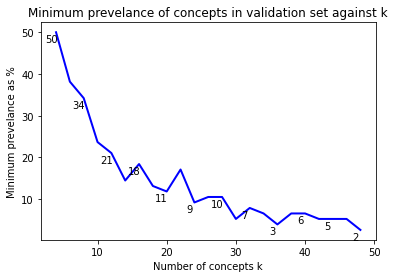

In [103]:
#plt.plot(ks,dt_train)
#plt.plot(ks,dt_val)
#plt.plot(ks,pp_node)
min_prevelance = list(map(lambda x: x*100,map(min,prevelance)))
plt.plot(ks,min_prevelance,lw=2,c="b")
for i,min_prev in enumerate(min_prevelance[::2]):
    label = str(min_prev.int().item())
    i=i*2
    plt.annotate(label, # this is the text
                 (ks[i],min_prevelance[i]), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-5,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.xlabel("Number of concepts k")
plt.ylabel("Minimum prevelance as %")
plt.title("Minimum prevelance of concepts in validation set against k")
plt.show()

---
# Concept Discovery

---
# Concept Representation

In [35]:
# DISCOVER CONCEPTS

from tqdm import tqdm
from sklearn.cluster import KMeans,MiniBatchKMeans
import numpy as np


k=32


means = generate_concept_means(model,train_loader,k)



100%|██████████| 308/308 [00:21<00:00, 14.19it/s]


In [36]:
from torch.nn.functional import one_hot

def activation_to_concept(activation,means):
    return one_hot(torch.as_tensor(nearest_mean(activation,means)),len(means))

def activation_to_concept_graph(activations,means,k):
    output = torch.zeros(0,k)
    for i in range(len(activations)):
        concept = activation_to_concept(whiten(activations[i]).numpy(),means).unsqueeze(0)
        output = torch.cat([output,concept],dim=0)
    return output


def predict_activation_concept_from_graph(graph,means,k):
    global activations
    activations = []
    model(graph.x,graph.edge_index,graph.batch)
    ag = activations[0]
    return ag,activation_to_concept_graph(ag,means,k)



In [37]:
# For determining how what sort of cancer diagnosis a concept indicates

X_train = torch.zeros(0,k)
Y_train = torch.zeros(0)

for graph in tqdm(train_loader):
    num_nodes = len(graph.x)

    y = torch.zeros(num_nodes) + graph.y
    _,x = predict_activation_concept_from_graph(graph,means,k)
    X_train = torch.cat([X_train,x],dim=0)
    Y_train = torch.cat([Y_train,y],dim=0)



#class_condition_concepts_prob(freq,X_train[0:10000])

100%|██████████| 308/308 [01:34<00:00,  3.26it/s]


In [38]:
print(len(Y_train[X_train.argmax(dim=1)==2]))
freq = class_concept_joint_frequency(Y_train,X_train,k)

27834


280840it [00:06, 41484.82it/s]


In [39]:
p_class_given_concept = (freq.transpose(1,0)).int() # /freq.reshape(-1,4).sum(dim=1,keepdim=True))*100
print(freq.shape)
p_class_given_concept = ((freq/freq.transpose(1,0).sum(dim=1)).transpose(1,0)*100).int()
print(p_class_given_concept)

torch.Size([4, 32])
tensor([[ 2,  7, 69, 21],
        [10, 45,  9, 33],
        [35, 20, 20, 23],
        [ 0,  1, 41, 57],
        [45,  1, 41, 12],
        [18, 70,  6,  4],
        [ 0,  2,  6, 90],
        [ 1, 17, 70, 11],
        [ 7, 56, 28,  8],
        [ 0,  0, 40, 58],
        [ 0, 13, 63, 21],
        [ 0, 14, 84,  0],
        [ 0, 19, 40, 39],
        [ 1,  0, 81, 17],
        [59, 36,  2,  1],
        [ 5,  2, 75, 16],
        [42,  0, 53,  3],
        [ 6,  6, 32, 53],
        [ 1,  0, 70, 28],
        [78,  9,  5,  5],
        [ 4, 81,  1, 12],
        [ 8, 57, 14, 18],
        [27, 27, 37,  6],
        [ 1, 95,  1,  1],
        [ 1, 18,  8, 71],
        [ 0, 85,  9,  4],
        [ 0,  4, 17, 76],
        [37,  5, 35, 21],
        [47, 33,  7, 10],
        [15,  0, 63, 20],
        [ 4,  0, 40, 54],
        [ 2, 75, 10, 11]], dtype=torch.int32)


In [40]:
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx

#todo rename
def activation_graph_to_concept_graph(graph,means,k):
    output = graph.clone()
    output.activation,output.x = predict_activation_concept_from_graph(graph,means,k)
    return output


def disect_concept_graph(concept_graph,min_subgraph_size=5):
    graph = concept_graph.clone()

    left_nodes,right_nodes = concept_graph.x[graph.edge_index[0,:]].argmax(dim=1),concept_graph.x[graph.edge_index[1,:]].argmax(dim=1)

    keep_edge = left_nodes==right_nodes
    graph.edge_index = graph.edge_index[:,keep_edge]
    
    G = to_networkx(graph, to_undirected=True, node_attrs=['x','activation','pos'])
    
    sub_graphs = [G.subgraph(g) for g in nx.components.connected_components(G) if len(g) >= min_subgraph_size]
    for i,g in enumerate(sub_graphs):
        g = from_networkx(g,group_node_attrs=['activation','x','pos'])
        g.pos = g.x[:,-2:]
        g.activation = g.x[:,:32]
        g.x = g.x[:,32:-2]
        g.graph_id = graph.graph_id
        g.y = graph.y.item()

        g.concept = g.x[0].argmax()
        sub_graphs[i] = g
    return sub_graphs


        
graph = next(iter(train_loader))


cg = activation_graph_to_concept_graph(graph[0],means,k)
print(disect_concept_graph(cg,min_subgraph_size=10))

[Data(edge_index=[2, 62], x=[12, 32], pos=[12, 2], activation=[12, 32], graph_id=[1], y=0, concept=1), Data(edge_index=[2, 810], x=[145, 32], pos=[145, 2], activation=[145, 32], graph_id=[1], y=0, concept=2), Data(edge_index=[2, 200], x=[39, 32], pos=[39, 2], activation=[39, 32], graph_id=[1], y=0, concept=27), Data(edge_index=[2, 130], x=[23, 32], pos=[23, 2], activation=[23, 32], graph_id=[1], y=0, concept=28), Data(edge_index=[2, 40], x=[10, 32], pos=[10, 2], activation=[10, 32], graph_id=[1], y=0, concept=28), Data(edge_index=[2, 302], x=[51, 32], pos=[51, 2], activation=[51, 32], graph_id=[1], y=0, concept=2)]


In [41]:
# GET ALL CANDIDATE EXEMPLARY GRAPHS
exemplary_concept_graphs = [[] for i in range(k)]

for i,graph in tqdm(enumerate(train_loader),total=len(train_loader)):
    sub_graphs = disect_concept_graph(activation_graph_to_concept_graph(graph[0],means,k),min_subgraph_size=5)
    for sg in sub_graphs:
        exemplary_concept_graphs[sg.concept].append(sg)

100%|██████████| 308/308 [01:57<00:00,  2.62it/s]


In [42]:
list(map(len,exemplary_concept_graphs))

[292,
 1034,
 1086,
 485,
 435,
 465,
 320,
 86,
 164,
 281,
 330,
 51,
 661,
 145,
 306,
 196,
 131,
 775,
 130,
 427,
 455,
 375,
 330,
 119,
 552,
 126,
 636,
 810,
 958,
 266,
 469,
 335]

In [43]:
# FILTER FOR 3 most Interesting

def sieve_graph_id(li):
    output = []
    for i,(score,g) in enumerate(li):
        unique = True
        for j,g2 in enumerate(output):
            if g.graph_id == g2.graph_id:
                unique = False
                break
        if unique:
            output.append(g)
    return output



exemplary_concept_graphs_final = list(exemplary_concept_graphs)
print(len(exemplary_concept_graphs_final))

def score_subgraph(sg,mean):
    dists = ((sg.activation - mean)**2).sum(dim=1)
    assert len(dists)==len(sg.activation)
    return dists.median()

for cons in tqdm(range(k)):
    
    #only_supporting_graphs = list(filter(lambda g: g.y== p_class_given_concept[cons].argmax(),exemplary_concept_graphs[cons]))
    #if len(only_supporting_graphs)==0:
    #    print(cons,p_class_given_concept[cons].argmax(),list(map(lambda x: x.y, exemplary_concept_graphs[cons])))
    best_examples = sieve_graph_id(sorted(map(lambda x:(score_subgraph(x,means[cons]),x),exemplary_concept_graphs[cons]),key=lambda x:x[0]))
    
    best_examples = best_examples[:min(3,len(best_examples))] 
    exemplary_concept_graphs_final[cons] = best_examples
    


32


100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


In [44]:
print(list(map(len,exemplary_concept_graphs_final)))

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [45]:
for cons in range(k):
    print(cons,list(map(lambda x: x.y, exemplary_concept_graphs_final[cons])))

0 [3, 2, 2]
1 [3, 3, 3]
2 [0, 3, 1]
3 [3, 3, 3]
4 [0, 0, 0]
5 [1, 1, 0]
6 [3, 3, 3]
7 [1, 1, 2]
8 [1, 1, 1]
9 [2, 3, 2]
10 [2, 1, 2]
11 [2, 1, 1]
12 [3, 3, 2]
13 [2, 2, 3]
14 [0, 0, 0]
15 [2, 2, 2]
16 [2, 0, 2]
17 [3, 3, 3]
18 [2, 2, 2]
19 [0, 1, 0]
20 [1, 1, 3]
21 [1, 1, 1]
22 [1, 0, 1]
23 [1, 1, 1]
24 [1, 3, 3]
25 [1, 3, 1]
26 [3, 3, 3]
27 [0, 0, 1]
28 [3, 0, 1]
29 [2, 2, 2]
30 [2, 3, 2]
31 [3, 1, 1]


In [52]:

bach_source=  os.path.join(parent, 'data', 'processed', 'BACH_TRAIN')
def bach_img_loc(img_id):
    b = BACH(bach_source)
    b.ids= list(range(1,401))
    img_path = b.original_image_paths[img_id-1]
    return img_path

def visualise_bach_subgraph(sg,crop=True,save=False,save_loc=None):

    img_path = bach_img_loc(sg.graph_id)
    visualise_concept_subgraph(sg,img_path,means,crop=crop,save=save,save_loc=save_loc)

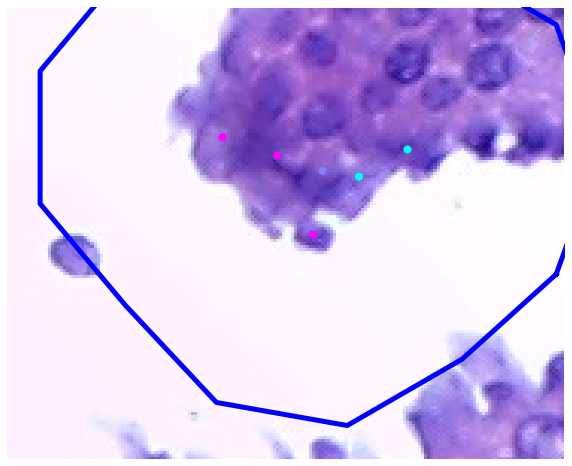

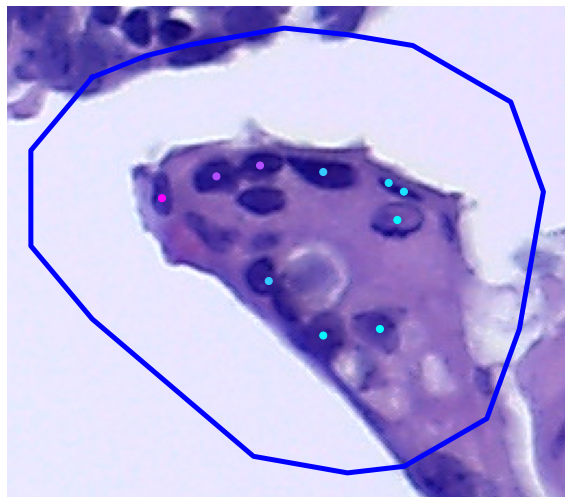

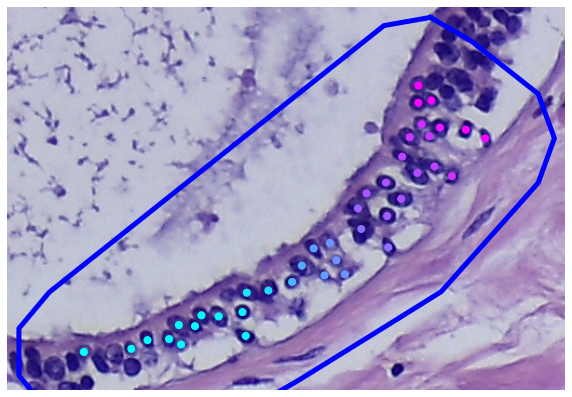

In [68]:
from src.datasets.BACH import BACH, _id_to_path
from PIL import Image
from scipy.spatial import ConvexHull
from src.transforms.graph_construction.hovernet_post_processing import cut_img_from_tile
from torchvision.transforms import ToTensor
from src.utilities.img_utilities import tensor_to_numpy

import matplotlib.pyplot as plt
from matplotlib import cm


def create_point_sphere(centre:torch.Tensor,radius,n_points):
    output = []
    for theta in np.linspace(0,2*np.pi,n_points):

        output += [centre + radius*torch.as_tensor([torch.cos(torch.as_tensor(theta)),torch.sin(torch.as_tensor(theta))])]
    return torch.stack(output)

def visualise_concept_subgraph(sg,image_loc,concept_means,crop=True,save=False,save_loc=None):
    # Load the image
    img = tensor_to_numpy(cut_img_from_tile(ToTensor()(Image.open(image_loc)),tile_size=128))
    # Place nodes on the image
    # Place smoothing sphere around cells
    # Convex hull around
    points = torch.zeros(0,2)
    centres = []
    distances = ((sg.activation - concept_means[sg.concept])**2).sum(dim=1)
    height = []
    for i in range(len(sg.x)):
        centre = sg.pos[i]
        centres.append(centre)
        height.append(distances[i])
        cell_points = create_point_sphere(centre,64,10)
        points = torch.cat([points,cell_points])
    points = points[ConvexHull(points.numpy()).vertices]
    points = torch.cat([points,points[0].unsqueeze(0)])
    centres = torch.stack(centres)
    height = torch.stack(height)
    height = (height-height.min())/(height.max()-height.min())
    colours = cm.cool(height)
    
    f = plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.plot(points[:,0].numpy(),points[:,1].numpy(),'b-',lw=5)
    plt.scatter(centres[:,0].numpy(),centres[:,1].numpy(),c =colours,s=50)
    if(crop):
        padding = 10
        xmin = int(max((points[:,0].numpy()-padding).min(),0))
        xmax = int(min((points[:,0].numpy()+padding).max(),img.shape[1]))
        ymin = int(max((points[:,1].numpy()-padding).min(),0))
        y_max = int(min((points[:,1].numpy()+padding).max(),img.shape[0]))
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,y_max)

    plt.imshow(img)
    
    if(save and save_loc is not None):
        plt.savefig(save_loc)
        plt.close(f)



    # Convert convex hull shape to shape object PIL
    # Fill shape and use as mask to place over image.
    # Colour border by concept number
    
i = 23
for j in range(3):
    visualise_bach_subgraph(exemplary_concept_graphs_final[i][j],crop = True)

In [54]:
from src.utilities.os_utilities import create_dir_if_not_exist
def save_discovered_concepts(folder_location,concept_means,exemplary_concept_graphs_final,class_concept_prob):
    create_dir_if_not_exist(folder_location,file_path=False)
    np.save(os.path.join(folder_location,'concept_means.npy'),concept_means)
    np.save(os.path.join(folder_location,'class_concept_prob.npy'),class_concept_prob)
    for cons in range(len(concept_means)):
        for i,cons_example in enumerate(exemplary_concept_graphs_final[cons]):
            visualise_bach_subgraph(cons_example,crop=True,save=True,save_loc=os.path.join(folder_location,'c'+str(cons)+'e'+str(i)+'.png'))

In [49]:
#save_discovered_concepts(os.path.join(parent, 'data', 'processed', 'CONCEPTS'),means,exemplary_concept_graphs_final,p_class_given_concept)

### Good ones
60

--- 
# Explaining Prediction

In [104]:
# TODO EXTEND TO LIST OF SUBGRAPHS
def visualise_concept_subgraphs(sgs,image_loc,concept_means,save=False,save_loc=None,ax=None,crop=False):
    if ax is None:
        f = plt.figure(figsize=(10,10))
        ax = f.add_subplot(111)
    plt.axis('off')
    # Load the image
    img = tensor_to_numpy(cut_img_from_tile(ToTensor()(Image.open(image_loc)),tile_size=128))
    # Place nodes on the image
    # Place smoothing sphere around cells
    # Convex hull around
    for sg in sgs:
        points = torch.zeros(0,2)
        centres = []
        distances = ((sg.activation - concept_means[sg.concept])**2).sum(dim=1)
        height = []
        for i in range(len(sg.x)):
            centre = sg.pos[i]
            centres.append(centre)
            height.append(distances[i])
            cell_points = create_point_sphere(centre,64,10)
            points = torch.cat([points,cell_points])
        points = points[ConvexHull(points.numpy()).vertices]
        points = torch.cat([points,points[0].unsqueeze(0)]) 
        ax.plot(points[:,0].numpy(),points[:,1].numpy(),'b-',lw=5)
        
    if(crop):
        padding = 10
        xmin = int(max((points[:,0].numpy()-padding).min(),0))
        xmax = int(min((points[:,0].numpy()+padding).max(),img.shape[1]))
        ymin = int(max((points[:,1].numpy()-padding).min(),0))
        y_max = int(min((points[:,1].numpy()+padding).max(),img.shape[0]))
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(ymin,y_max)

    ax.imshow(img,aspect='auto')
    
    if(save and save_loc is not None):
        plt.savefig(save_loc)
        plt.close(f)


102
d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis\data\processed\BACH_TRAIN\Benign\b002.tif
[tensor(20), tensor(14), tensor(20), tensor(14), tensor(23), tensor(23), tensor(14), tensor(5), tensor(5), tensor(20), tensor(14), tensor(20), tensor(23), tensor(5), tensor(23), tensor(14)]


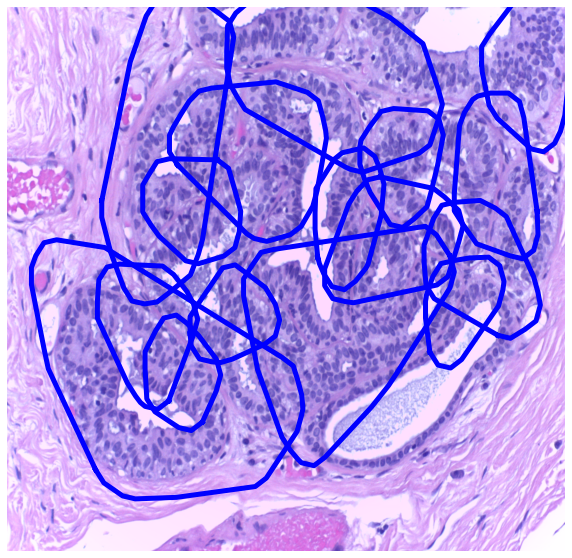

In [105]:
i = 73
graph = train_loader.dataset[i]
print(graph.graph_id)
print(bach_img_loc(graph.graph_id))
concept_graph = activation_graph_to_concept_graph(graph,means,k)
sgs = disect_concept_graph(concept_graph,min_subgraph_size=20)
print(list(map(lambda x:x.concept,sgs)))
visualise_concept_subgraphs(sgs,bach_img_loc(graph.graph_id),means)


In [106]:
    #p_canc_given_concept = torch.zeros(k,2)
    #p_canc_given_concept[:,0] = p_class_given_concept[:,0] + p_class_given_concept[:,1]
    #p_canc_given_concept[:,1] = p_class_given_concept[:,2] + p_class_given_concept[:,3]
    #p_canc_given_concept

[Data(edge_index=[2, 200], x=[39, 32], pos=[39, 2], activation=[39, 32], graph_id=102, y=1, concept=23), Data(edge_index=[2, 170], x=[31, 32], pos=[31, 2], activation=[31, 32], graph_id=102, y=1, concept=23), Data(edge_index=[2, 90], x=[19, 32], pos=[19, 2], activation=[19, 32], graph_id=102, y=1, concept=23), Data(edge_index=[2, 96], x=[18, 32], pos=[18, 2], activation=[18, 32], graph_id=102, y=1, concept=23), Data(edge_index=[2, 98], x=[21, 32], pos=[21, 2], activation=[21, 32], graph_id=102, y=1, concept=23), Data(edge_index=[2, 116], x=[24, 32], pos=[24, 2], activation=[24, 32], graph_id=102, y=1, concept=23)]


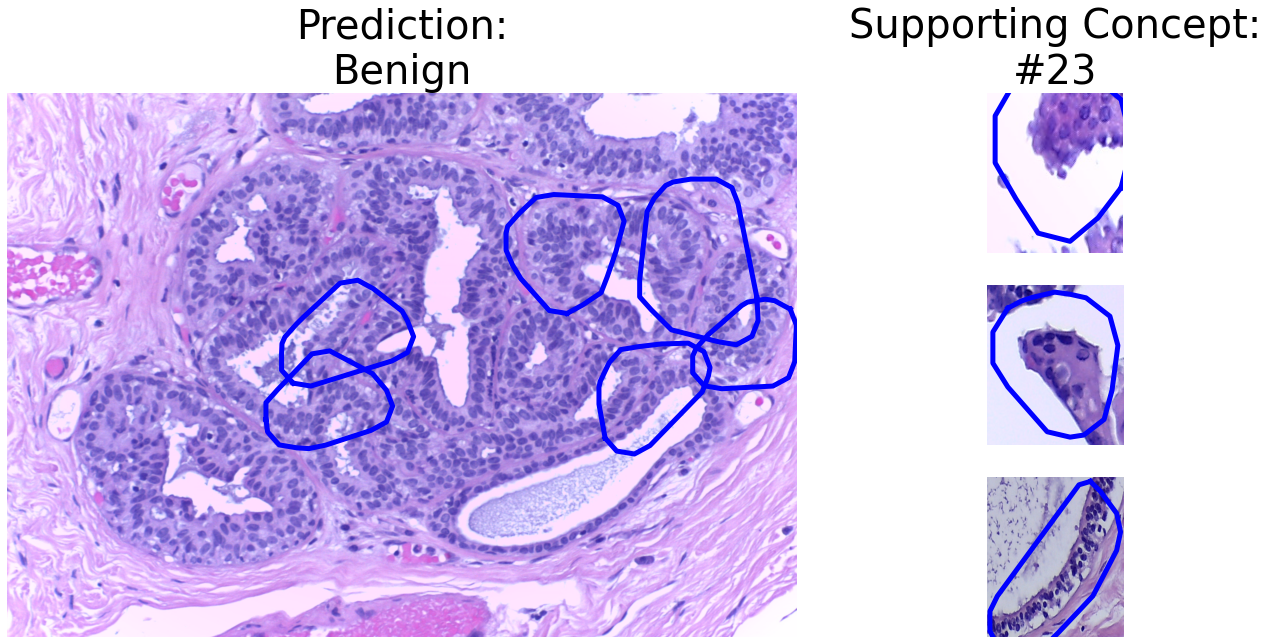

In [144]:
from matplotlib.gridspec import GridSpec



def explain_prediction(graph,prediction,means,k,p_class_given_concept,exemplary_concept_graphs_final):
    # ORDER BY COUNT
    sgs = disect_concept_graph(activation_graph_to_concept_graph(graph,means,k),min_subgraph_size=15)
    assert p_class_given_concept.shape == (k,4)
    #p_canc_given_concept = torch.zeros(k,2)
    #p_canc_given_concept[:,0] = p_class_given_concept[:,0] + p_class_given_concept[:,1]+1
    #p_canc_given_concept[:,1] = p_class_given_concept[:,2] + p_class_given_concept[:,3]+1 #laplace smoothing
    #
    #is_canc = prediction>=2
    #canc_evidence = sorted(list(filter(lambda g:p_canc_given_concept[g.concept][1]>50,sgs)),key=lambda g:p_canc_given_concept[g.concept][1],reverse=True)
    #non_canc_evidence = sorted(list(filter(lambda g:p_canc_given_concept[g.concept][0]>50,sgs)),key=lambda g:p_canc_given_concept[g.concept][0],reverse=True)
    #if is_canc:
    #    support,contrary = canc_evidence,non_canc_evidence
    #else:
    #    support,contrary = non_canc_evidence,canc_evidence
    #    
    #return support,contrary
    
    evidence = sorted(list(filter(lambda g:p_class_given_concept[g.concept][prediction]>50,sgs)),key=lambda g:p_class_given_concept[g.concept][prediction],reverse=True)
    primary_concept = evidence[0].concept
    primary_evidence = list(filter(lambda g:g.concept==primary_concept,evidence))
    print(primary_evidence)
    
    f = plt.figure(figsize=(20,10))
    gs = GridSpec(nrows=3, ncols=7)
    ax_main = f.add_subplot(gs[:,:5])
    ax_main.title.set_text('Prediction:\n'+['Normal','Benign','In-Situ','Invasive'][prediction])
    ax_main.title.set_fontsize(40)
    visualise_concept_subgraphs(primary_evidence,bach_img_loc(graph.graph_id),means,ax=ax_main)
    ax_concepts = [f.add_subplot(gs[i:i+1,6:]) for i in range(3)]
    ax_concepts[0].title.set_text('Supporting Concept:\n#'+str(primary_concept.item()))
    ax_concepts[0].title.set_fontsize(40)
    for i,sg in enumerate(exemplary_concept_graphs_final[primary_concept]):
        ax_concepts[i].axis('off')
        visualise_concept_subgraphs([sg],bach_img_loc(sg.graph_id),means,ax=ax_concepts[i],crop=True)
    
    
graph_pred = model(graph.x,graph.edge_index,graph.batch)

evidence = explain_prediction(graph,graph_pred.argmax(),means,k,p_class_given_concept,exemplary_concept_graphs_final)

#visualise_concept_subgraphs(evidence,bach_img_loc(graph.graph_id),means)
        
    